In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Path to the image directory and CSV file
image_dir = "./data/imgs"
csv_file = "./data/train.csv"

# Reading the CSV file using Pandas
data = pd.read_csv(csv_file)

In [3]:
X = []
y = []

# Function to load images and apply Sobel filter
def load_images_sobel(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640, 640))  # Resize the image to 640x640
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    return sobel

for index, row in data.iterrows():
    image_name = row['Image']
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        sobel_image = load_images_sobel(image_path)
        X.append(sobel_image)
        y.append(int(row['whaleID'].split("_")[1]))

In [4]:
# Convert the lists to numpy arrays
X = np.array(X) # Images with Sobel filter
y = np.array(y) # Corresponding whale IDs

# Display the shape of the data
print(f"Shape of X (images with Sobel filter): {X.shape}")
print(f"Shape of y (whale IDs): {y.shape}")

Shape of X (images with Sobel filter): (4543, 640, 640)
Shape of y (whale IDs): (4543,)


In [5]:
X[0].shape

(640, 640)

In [6]:
y[0]

48813

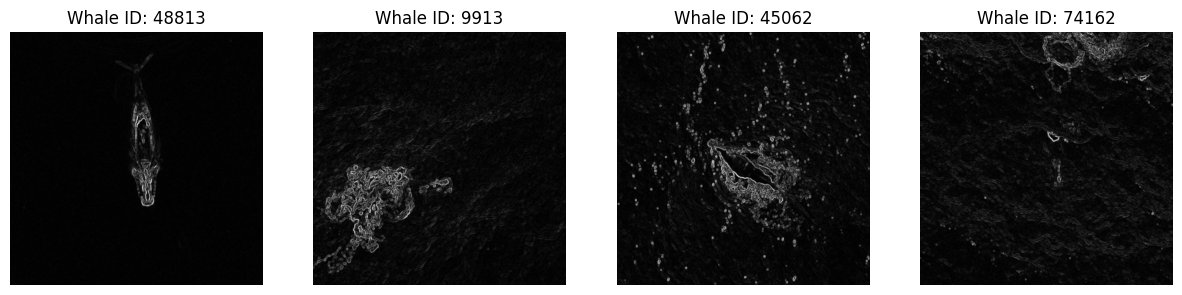

In [7]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title(f"Whale ID: {y[i]}")
    axes[i].axis('off')

plt.show()

In [8]:
# Define the Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return torch.Tensor(image).unsqueeze(0), torch.Tensor([label])

# Create the dataset
dataset = CustomDataset(X, y)

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [9]:
# Assuming you have defined your neural network model, let's create a simple example network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 160 * 160, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 160 * 160)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, optimizer, and loss function
model = SimpleNet()

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

model.to(device)

In [10]:
criterion = nn.MSELoss()  # You may need to change the loss function based on the task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:  # Print every 10 mini-batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Batch [{i + 1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 10}")
            running_loss = 0.0

print("Finished Training")

Epoch [1/10], Batch [10/114], Loss: 2527192985.6
Epoch [1/10], Batch [20/114], Loss: 1513783385.6
Epoch [1/10], Batch [30/114], Loss: 1414721638.4
Epoch [1/10], Batch [40/114], Loss: 1457686828.8
Epoch [1/10], Batch [50/114], Loss: 1158738476.8
Epoch [1/10], Batch [60/114], Loss: 1199984198.4
Epoch [1/10], Batch [70/114], Loss: 1399617734.4
Epoch [1/10], Batch [80/114], Loss: 1299557785.6
Epoch [1/10], Batch [90/114], Loss: 1408375929.6
Epoch [1/10], Batch [100/114], Loss: 1223597593.6
Epoch [1/10], Batch [110/114], Loss: 1353271078.4
Epoch [2/10], Batch [10/114], Loss: 1078272281.6
Epoch [2/10], Batch [20/114], Loss: 1162412576.0
Epoch [2/10], Batch [30/114], Loss: 1190543091.2
Epoch [2/10], Batch [40/114], Loss: 1162051872.0
Epoch [2/10], Batch [50/114], Loss: 1130341907.2
Epoch [2/10], Batch [60/114], Loss: 1199974803.2
Epoch [2/10], Batch [70/114], Loss: 1140307027.2
Epoch [2/10], Batch [80/114], Loss: 1213865177.6
Epoch [2/10], Batch [90/114], Loss: 1156403161.6
Epoch [2/10], Batc

In [ ]:
# Evaluate the model on the test set
model.eval()
total = 0
correct = 0


for data in test_loader:
    inputs, labels = data
    outputs = model(inputs)
    acc = (outputs.round() == labels).float().mean()
    acc = float(acc)
    print(f"Accuracy: {acc}")

# Save the model if needed
# torch.save(model.state_dict(), 'your_model.pth')

Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
